In [ ]:
#|default_exp layouts

In [ ]:
#| hide
%load_ext autoreload
%autoreload 2

In [ ]:
#|hide
from nbdev.showdoc import *

In [ ]:
#| export

from clip_plot.utils import timestamp, get_path, write_json, read_json, round_floats, FILE_NAME
from clip_plot.utils import datestring_to_date, round_date, date_to_seconds

import os
import json
import math
import pickle
import itertools
from typing import List
from collections import defaultdict

import numpy as np

import operator
import multiprocessing

# TODO: Change math references to numpy

from hdbscan import HDBSCAN
# surprise, surprise -- UMAP imports tensorflow if its available
# this will print ugly warnings unless you set a high log level
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
from umap import UMAP, AlignedUMAP

from sklearn.decomposition import PCA
from sklearn.preprocessing import minmax_scale
from scipy.stats import kde


import rasterfairy
from rasterfairy import coonswarp
from pointgrid import align_points_to_grid
import matplotlib.pyplot as plt


## Set some constants we want to remove later

In [ ]:
#| export

## Ignoring cuml-umap for now to avoid conditional import
## We may add cuml-umap option back later
## if profiling shows it may give speedup

## TODO: Profile clip-plot on mnist as worst-case for umap (cheap embeddings, high number of points)

cuml_ready = False
cluster_method = "hdbscan"


## Layouts and their inputs

It's useful to think of layouts and the required data to generate them:

### No data:
- alphabetical layout
    - Only requires the total amount of images to generate the layout  
  <br>
  <br>
### Embeddings:
- umap layout
    - Uses embeddings (vecs) to generate layout
    - Under some circumstances it will uses metadata (labels)
- rasterfairy
    - uses umap layout
  <br>
  <br>
### Metadata:
- categorical layout
    - uses "category" data from metadata
- date layout
    - uses "date" data from metadata
- custom layout
    - uses "x" & "y" data from metadata
- geographic layout
    - uses "lat" & "lng" data from metadata
    - Can use a geoJson to create/use custom boundary/map
        - E.g. Replace world map with map of USA
***

## Layouts and their outputs

It's useful to think of layouts and how they output their data (to be consumed by the web application)

All layouts output a .json composed of list of list as follows:
<blockquote>
[<br>
    [<br>
        x, # x-coordinate of 1st image<br> 
        y # y-coordinate of 1st image<br>
    ],<br>
    [<br>
        x, # x-coordinate of 2nd image<br> 
        y # y-coordinate of 2nd image<br>
    ],<br>
    . . . ,<br>
]
</blockquote>

Some layouts will also output a label file specifying labels and their position:
  - Category layouts
  - Date layouts (named "timeline-{plot_id}.json" and "timeline-labels-{plot_id}.json")  
  
<br>  
All layouts (and their label file if applicable) are specified in the manifest.json  <br>

The umap layout is unique in the cense that you can create "variants" by specifying more than one n_neighbors and/or min_dist.  
Clip-plot will generate len(n_neighbors) * len(min_dist) number of variants:  
  - E.g. n_neighbors=[7,15] and min_dist=[.005, .001] will generate 2*2=4 variants  

Each variant is saved as its own file (e.g. "umap-n_neighbors_{n_neighbors_}-min_dist_{min_dist}-{plot_id}.json")  
In addition, each variant (even if there is only one), will have a jittered file saved as well

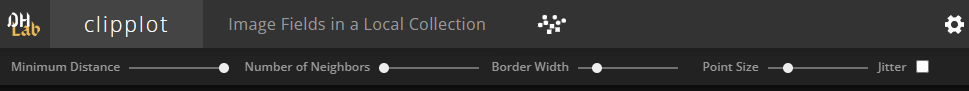
***

# Create layouts based on dimensionality reduction or other

In [ ]:
#| export
from abc import ABC, abstractmethod

class BaseLayout(ABC):
    # Required property values
    SUBDIR = "layouts"
    FILENAME = ""
    LABEL_FILENAME = ""
    DEFAULT_OPTIONS = {
        'scale': True, 
        'round': True,
        'use_cache': False,
        'gzip': False,
        "encoding": "utf8",
        "add_hash": True
    }

    def __init__(self, plot_id, out_dir):
        self.plot_id = plot_id
        self.out_dir = out_dir

        # Required property values
        self.scale = self.DEFAULT_OPTIONS['scale']
        self.round = self.DEFAULT_OPTIONS['round']
        self.gzip = self.DEFAULT_OPTIONS['gzip']
        self.encoding = self.DEFAULT_OPTIONS['encoding']
        self.add_hash = self.DEFAULT_OPTIONS['add_hash']

    @property
    def jsonOptions(self):
        return {'gzip': self.gzip, 'encoding': self.encoding} 

    def write_layout(self, path, obj):
        """Write layout json `obj` to disk and return the path to the saved file
        
        Args:
            path (str)
            obj (array object) (e.g. np.ndarray)
            **scale (Optional)
            **round (Optional)

            Subfunctions
                write_json()
                    path (str)
                    obj (json serializable)
                    **gzip (Optional[bool]): Default = False
                    **encoding (str): Required if gzip = True

        """
        if self.scale is True:
            obj = (minmax_scale(obj) - 0.5) * 2  # scale -1:1
        if self.round is True:
            obj = round_floats(obj)
        if isinstance(obj, np.ndarray):
            obj = obj.tolist()

        return write_json(path, obj, **self.jsonOptions)
    
    @abstractmethod
    def get_layout(self):
        # Get or create layout
        pass

    def get_path(self, filename=None):
        if filename is None:
            filename = self.FILENAME
        pathDict = {
            "out_dir": self.out_dir,
            "add_hash": self.add_hash,
            "plot_id": self.plot_id,
            "gzip": self.gzip}
        
        return get_path(self.SUBDIR, filename, **pathDict)

    

class AlphabeticLayout(BaseLayout):

    DEFAULT_OPTIONS = BaseLayout.DEFAULT_OPTIONS.copy()
    SUBDIR = "layouts"
    FILENAME = "grid"

    def __init__(self, plot_id, imageEngine, options={}) -> None:
        super().__init__(plot_id, imageEngine.out_dir)

        self.imageEngine = imageEngine
        
        # Load options
        for option, default in self.DEFAULT_OPTIONS.items():
            setattr(self, option, options.get(option, default))

    def get_layout(self):
        """Get the x,y positions of images in a grid projection
        
        Args:
            use_cache

            subfunction
                get_path()
                    *sub_dir (str)
                    *filename (str)
                    **out_dir (str)
                    **add_hash (Optional[bool])
                    **plot_id (Optional[str]): Required if add_hash is True


                write_layout()
                    path (str)
                    obj (array object) (e.g. np.ndarray)
                    scale (Optional)
                    round (Optional)

                    Subfunctions
                        write_json()
                            path (str)
                            obj (json serializable)
                            **gzip (Optional[bool]): Default = False
                            **encoding (str): Required if gzip = True

        """
        print(timestamp(), "Creating grid layout")        
        out_path = self.get_path()
        if os.path.exists(out_path) and self.use_cache:
            return out_path
        n = math.ceil(self.imageEngine.count ** (1 / 2))
        l = []  # positions
        for i in range(self.imageEngine.count):
            x = i % n
            y = math.floor(i / n)
            l.append([x, y])
        z = np.array(l)

        return self.write_layout(out_path, z)
    

class CategoricalLayout(BaseLayout):

    DEFAULT_OPTIONS = BaseLayout.DEFAULT_OPTIONS.copy()
    DEFAULT_OPTIONS.update({
        "null_category": "Other",
        "margin": 2
    })

    FILENAME = "categorical"
    LABEL_FILENAME = "categorical-labels"

    def __init__(self, plot_id, imageEngine, options={}) -> None:
        super().__init__(plot_id, imageEngine.out_dir)

        self.imageEngine = imageEngine
        
        # Load options
        for option, default in self.DEFAULT_OPTIONS.items():
            setattr(self, option, options.get(option, default))

    def get_layout(self):
        """
        Return a numpy array with shape (n_points, 2) with the point
        positions of observations in box regions determined by
        each point's category metadata attribute (if applicable)

        Args:
            null_category (Optional[str]='Other')
            margin (Optional[int]=2)
            metadata

            subfunction
                get_path()
                    *sub_dir (str)
                    *filename (str)
                    **out_dir (str)
                    **add_hash (Optional[bool])
                    **plot_id (Optional[str]): Required if add_hash is True

                    write_json()
                        path (str)
                        obj (json serializable)
                        **gzip (Optional[bool]): Default = False
                        **encoding (str): Required if gzip = True
        """

        if "category" not in self.imageEngine.meta_headers:
            return False
        
        print(timestamp(), "Creating categorical layout")
        # determine the out path and return from cache if possible
        out_path = self.get_path()
        labels_out_path = self.get_path("categorical-labels")

        # accumulate d[category] = [indices of points with category]
        categories = [img.metadata.get("category", None) for img in self.imageEngine]
        if not any(categories) or len(set(categories) - set([None])) == 1:
            return False
        d = defaultdict(list)
        for idx, i in enumerate(categories):
            d[i].append(idx)

        # store the number of observations in each group
        keys_and_counts = [{"key": i, "count": len(d[i])} for i in d]
        keys_and_counts.sort(key=operator.itemgetter("count"), reverse=True)
        # get the box layout then subdivide into discrete points
        boxes = get_categorical_boxes([i["count"] for i in keys_and_counts], margin=self.margin)
        points = get_categorical_points(boxes)
        # sort the points into the order of the observations in the metadata
        counts = {i["key"]: 0 for i in keys_and_counts}
        offsets = {i["key"]: 0 for i in keys_and_counts}
        for idx, i in enumerate(keys_and_counts):
            offsets[i["key"]] += sum([j["count"] for j in keys_and_counts[:idx]])
        sorted_points = []
        for img in self.imageEngine:
            category = img.metadata.get("category", self.null_category)
            sorted_points.append(points[offsets[category] + counts[category]])
            counts[category] += 1
        sorted_points = np.array(sorted_points)
        # add to the sorted points the anchors for the text labels for each group
        text_anchors = np.array([[i.x, i.y - self.margin / 2] for i in boxes])
        # add the anchors to the points - these will be removed after the points are projected
        sorted_points = np.vstack([sorted_points, text_anchors])
        # scale -1:1 using the largest axis as the scaling metric
        _max = np.max(sorted_points)
        for i in range(2):
            _min = np.min(sorted_points[:, i])
            sorted_points[:, i] -= _min
            sorted_points[:, i] /= _max - _min
            sorted_points[:, i] -= np.max(sorted_points[:, i]) / 2
            sorted_points[:, i] *= 2
        # separate out the sorted points and text positions
        text_anchors = sorted_points[-len(text_anchors) :]
        sorted_points = sorted_points[: -len(text_anchors)]
        z = round_floats(sorted_points.tolist())
        return {
            "layout": write_json(out_path, z, **self.jsonOptions),
            "labels": write_json(
                labels_out_path,
                {
                    "positions": round_floats(text_anchors.tolist()),
                    "labels": [i["key"] for i in keys_and_counts],
                },
                **self.jsonOptions
            ),
        }

In [ ]:
#| export

def write_layout(path, obj, **kwargs):
    """Write layout json `obj` to disk and return the path to the saved file
    
    Args:
        path (str)
        obj (array object) (e.g. np.ndarray)
        **scale (Optional)
        **round (Optional)

        Subfunctions
            write_json()
                path (str)
                obj (json serializable)
                **gzip (Optional[bool]): Default = False
                **encoding (str): Required if gzip = True

    """
    if kwargs.get("scale", True) != False:
        obj = (minmax_scale(obj) - 0.5) * 2  # scale -1:1
    if kwargs.get("round", True) != False:
        obj = round_floats(obj)
    if isinstance(obj, np.ndarray):
        obj = obj.tolist()
    return write_json(path, obj, **kwargs)


In [ ]:
#| export

def get_pointgrid_layout(path, label, **kwargs):
    """Gridify the positions in `path` and return the path to this new layout
    
    Args:
        path (str)
        label (str)
        use_cache (Optional[bool])

        subfunctions
            get_path()
                *sub_dir (str) (hardcoded)
                *filename (str) (hardcoded)
                **out_dir (str)
                **add_hash (Optional[bool])
                **plot_id (Optional[str]): Required if add_hash is True
                
            read_json()
                path (str)
                **gzip (Optional[bool]): Default = False
                **encoding (str): Required if gzip = True

            write_layout()
                path (str)
                obj (array object) (e.g. np.ndarray)
                **scale (Optional)
                **round (Optional)

                Subfunctions
                    write_json()
                        path (str)
                        obj (json serializable)
                        **gzip (Optional[bool]): Default = False
                        **encoding (str): Required if gzip = True
    """
    print(timestamp(), "Creating {} pointgrid".format(label))
    out_path = get_path("layouts", label + "-jittered", **kwargs)
    if os.path.exists(out_path) and kwargs["use_cache"]:
        return out_path
    
    arr = np.array(read_json(path, **kwargs))
    if arr.shape[-1] != 2:
        print(timestamp(), "Could not create pointgrid layout because data is not 2D")
        return None
    
    z = align_points_to_grid(arr, fill=0.01)
    return write_layout(out_path, z, **kwargs)


In [ ]:
#| export

def get_umap_layout(imageEngine, **kwargs):
    """Get the x,y positions of images passed through a umap projection
    
    Args:
        umap_on_full_dims (bool)
        vecs
        n_neighbors
        min_dist

        subfunctions
            process_single_layout_umap()
                v (array like object)
                **use_cache
                **metadata (Optional)
                **n_neighbors
                **min_dist

                Subfunctions
                    get_umap_model()
                        **n_neighbors
                        **min_dist
                        **n_components
                        **seed
                        **metric

                    get_path()
                        *sub_dir (str)
                        *filename (str)
                        **out_dir (str)
                        **add_hash (Optional[bool])
                        **plot_id (Optional[str]): Required if add_hash is True

                    write_layout()
                        path (str)
                        obj (array object) (e.g. np.ndarray)
                        **scale (Optional)
                        **round (Optional)

                    write_json()
                        path (str)
                        obj (json serializable)
                        **gzip (Optional[bool]): Default = False
                        **encoding (str): Required if gzip = True

                    get_pointgrid_layout()
                        path (str)
                        label (str)
                        **use_cache (Optional[bool])

                        subfunctions
                            read_json()
                                path (str)
                                **gzip (Optional[bool]): Default = False
                                **encoding (str): Required if gzip = True

            process_multi_layout_umap()
                v (array like object)
                **n_neighbors
                **min_dist
                **images
                **out_dir

                Subfunctions
                    get_path()
                        *sub_dir (str)
                        *filename (str)
                        **out_dir (str)
                        **add_hash (Optional[bool])
                        **plot_id (Optional[str]): Required if add_hash is True

                    write_layout()
                        path (str)
                        obj (array object) (e.g. np.ndarray)
                        **scale (Optional)
                        **round (Optional)

                    write_json()
                        path (str)
                        obj (json serializable)
                        **gzip (Optional[bool]): Default = False
                        **encoding (str): Required if gzip = True

                    get_pointgrid_layout()
                        path (str)
                        label (str)
                        **use_cache (Optional[bool])

                        subfunctions
                            read_json()
                                path (str)
                                **gzip (Optional[bool]): Default = False
                                **encoding (str): Required if gzip = True

    """

    vecs = kwargs["vecs"]
    if kwargs["umap_on_full_dims"]: 
        w = vecs
    else: 
        w = PCA(n_components=min(100, len(vecs))).fit_transform(vecs)

    # Single model umap?
    if len(kwargs["n_neighbors"]) == 1 and len(kwargs["min_dist"]) == 1:
        return process_single_layout_umap(w, imageEngine, **kwargs)
    else:
        return process_multi_layout_umap(w, **kwargs)


def process_single_layout_umap(v, imageEngine, **kwargs):
    """Create a single layout UMAP projection

    Notes:
    - This also returns rasterfairy 
    
    Args:
        v (array like object)
        use_cache
        metadata (Optional)
        n_neighbors
        min_dist

        Subfunctions
            get_umap_model()
                **n_neighbors
                **min_dist
                **n_components
                **seed
                **metric

            get_path()
                *sub_dir (str)
                *filename (str)
                **out_dir (str)
                **add_hash (Optional[bool])
                **plot_id (Optional[str]): Required if add_hash is True

            write_layout()
                path (str)
                obj (array object) (e.g. np.ndarray)
                **scale (Optional)
                **round (Optional)

            write_json()
                path (str)
                obj (json serializable)
                **gzip (Optional[bool]): Default = False
                **encoding (str): Required if gzip = True

            get_pointgrid_layout()
                path (str)
                label (str)
                **use_cache (Optional[bool])

                subfunctions
                    read_json()
                        path (str)
                        **gzip (Optional[bool]): Default = False
                        **encoding (str): Required if gzip = True
        
    """
    print(timestamp(), "Creating single umap layout")
    model = get_umap_model(**kwargs)
    out_path = get_path("layouts", "umap", **kwargs)
    if cuml_ready:
        z = model.fit(v).embedding_
    else:
        if os.path.exists(out_path) and kwargs["use_cache"]:
            return out_path
        y = []
        if "label" in imageEngine.meta_headers:
            labels = [img.metadata.get("label", None) for img in imageEngine]
            # if the user provided labels, integerize them
            if any([i for i in labels]):
                d = defaultdict(lambda: len(d))
                for i in labels:
                    if i == None:
                        y.append(-1)
                    else:
                        y.append(d[i])
                y = np.array(y)
        # project the PCA space down to 2d for visualization
        z = model.fit(v, y=y if np.any(y) else None).embedding_
    return {
        "variants": [
            {
                "n_neighbors": kwargs["n_neighbors"][0],
                "min_dist": kwargs["min_dist"][0],
                "layout": write_layout(out_path, z, **kwargs),
                "jittered": get_pointgrid_layout(out_path, "umap", **kwargs),
            }
        ]
    }


def process_multi_layout_umap(v, **kwargs):
    """Create a multi-layout UMAP projection
    
    Args:
        v (array like object)
        n_neighbors
        min_dist
        images
        out_dir

        Subfunctions
            get_path()
                *sub_dir (str)
                *filename (str)
                **out_dir (str)
                **add_hash (Optional[bool])
                **plot_id (Optional[str]): Required if add_hash is True

            write_layout()
                path (str)
                obj (array object) (e.g. np.ndarray)
                scale (Optional)
                round (Optional)

            write_json()
                path (str)
                obj (json serializable)
                **gzip (Optional[bool]): Default = False
                **encoding (str): Required if gzip = True

            get_pointgrid_layout()
                path (str)
                label (str)
                **use_cache (Optional[bool])

                subfunctions
                    read_json()
                        path (str)
                        **gzip (Optional[bool]): Default = False
                        **encoding (str): Required if gzip = True
    
    """
    print(timestamp(), "Creating multi-umap layout")
    params = []
    for n_neighbors, min_dist in itertools.product(
        kwargs["n_neighbors"], kwargs["min_dist"]
    ):
        filename = "umap-n_neighbors_{}-min_dist_{}".format(n_neighbors, min_dist)
        out_path = get_path("layouts", filename, **kwargs)
        params.append(
            {
                "n_neighbors": n_neighbors,
                "min_dist": min_dist,
                FILE_NAME: filename,
                "out_path": out_path,
            }
        )
    # map each image's index to itself and create one copy of that map for each layout
    relations_dict = {idx: idx for idx, _ in enumerate(v)}

    # determine the subset of params that have already been computed
    uncomputed_params = [i for i in params if not os.path.exists(i["out_path"])]

    # determine the filepath where this model will be saved
    model_filename = "umap-" + str(abs(hash(kwargs["images"])))
    model_path = get_path("models", model_filename, **kwargs).replace(".json", ".gz")
    out_dir = os.path.join(kwargs["out_dir"], "models")
    if not os.path.exists(out_dir):
        os.makedirs(out_dir)

    # load or create the model
    if os.path.exists(model_path):
        model = load_model(model_path)
        for i in uncomputed_params:
            model.update(v, relations_dict.copy())
    
        # after updating, we can read the results from the end of the updated model
        for idx, i in enumerate(uncomputed_params):
            embedding = z.embeddings_[len(uncomputed_params) - idx]
            write_layout(i["out_path"], embedding, **kwargs)
    else:
        model = AlignedUMAP(
            n_neighbors=[i["n_neighbors"] for i in uncomputed_params],
            min_dist=[i["min_dist"] for i in uncomputed_params],
        )
        # fit the model on the data
        z = model.fit(
            [v for _ in params], relations=[relations_dict for _ in params[1:]]
        )
        for idx, i in enumerate(params):
            write_layout(i["out_path"], z.embeddings_[idx], **kwargs)
    
        # save the model
        save_model(model, model_path)

    # load the list of layout variants
    l = []
    for i in params:
        l.append(
            {
                "n_neighbors": i["n_neighbors"],
                "min_dist": i["min_dist"],
                "layout": i["out_path"],
                "jittered": get_pointgrid_layout(
                    i["out_path"], i[FILE_NAME], **kwargs
                ),
            }
        )
    return {
        "variants": l,
    }


def save_model(model: AlignedUMAP, path: str) -> None:
    """Save AlignedUMAP model as a pickle

    Args:
        model (AlignedUMAP)
        path (str)
    """
    try:
        params = model.get_params()
        attributes_names = [
            attr for attr in model.__dir__() if attr not in params and attr[0] != "_"
        ]
        attributes = {key: model.__getattribute__(key) for key in attributes_names}
        attributes["embeddings_"] = list(model.embeddings_)
        for x in ["fit", "fit_transform", "update", "get_params", "set_params"]:
            del attributes[x]
        all_params = {
            "umap_params": params,
            "umap_attributes": {key: value for key, value in attributes.items()},
        }
        pickle.dump(all_params, open(path, "wb"))
    except:
        print(timestamp(), "Could not save model")


def load_model(path: str) -> AlignedUMAP:
    """Load AlignedUMAP from pickle
    
    Args:
        path (str): Location of pickled AlignedUMAP model
    """
    params = pickle.load(open(path, "rb"))
    model = AlignedUMAP()
    model.set_params(**params.get("umap_params"))
    for attr, value in params.get("umap_attributes").items():
        model.__setattr__(attr, value)
    model.__setattr__(
        "embeddings_", List(params.get("umap_attributes").get("embeddings_"))
    )

    return model


def get_umap_model(**kwargs):
    """
    
    Args:
        n_neighbors
        min_dist
        n_components
        seed
        metric    
    """
    if cuml_ready:
        return UMAP(
            n_neighbors=kwargs["n_neighbors"][0],
            min_dist=kwargs["min_dist"][0],
            n_components=kwargs["n_components"],
            random_state=kwargs["seed"],
            verbose=5,
        )
    else:
        return UMAP(
            n_neighbors=kwargs["n_neighbors"][0],
            min_dist=kwargs["min_dist"][0],
            n_components=kwargs["n_components"],
            metric=kwargs["metric"],
            random_state=kwargs["seed"],
            transform_seed=kwargs["seed"],
        )

In [ ]:
#| export

def get_rasterfairy_layout(**kwargs):
    """Get the x, y position of images passed through a rasterfairy projection
    
    Args:
        use_cache
        umap

        subfunctions
            get_path()
                *sub_dir (str)
                *filename (str)
                **out_dir (str)
                **add_hash (Optional[bool])
                **plot_id (Optional[str]): Required if add_hash is True
            read_json()
                path (str)
                **gzip (Optional[bool]): Default = False
                **encoding (str): Required if gzip = True
            write_layout()
    
    """
    print(timestamp(), "Creating rasterfairy layout")
    out_path = get_path("layouts", "rasterfairy", **kwargs)
    if os.path.exists(out_path) and kwargs["use_cache"]:
        return out_path
    umap = np.array(read_json(kwargs["umap"]["variants"][0]["layout"], **kwargs))
    if umap.shape[-1] != 2:
        print(timestamp(), "Could not create rasterfairy layout because data is not 2D")
        return None
    umap = (umap + 1) / 2  # scale 0:1
    try:
        umap = coonswarp.rectifyCloud(
            umap,  # stretch the distribution
            perimeterSubdivisionSteps=4,
            autoPerimeterOffset=False,
            paddingScale=1.05,
        )
    except Exception as exc:
        print(timestamp(), "Coonswarp rectification could not be performed", exc)
    pos = rasterfairy.transformPointCloud2D(umap)[0]
    return write_layout(out_path, pos, **kwargs)


def get_alphabetic_layout(imageEngine, **kwargs):
    """Get the x,y positions of images in a grid projection
    
    Args:
        use_cache

        subfunction
            get_path()
                *sub_dir (str)
                *filename (str)
                **out_dir (str)
                **add_hash (Optional[bool])
                **plot_id (Optional[str]): Required if add_hash is True


            write_layout()
                path (str)
                obj (array object) (e.g. np.ndarray)
                scale (Optional)
                round (Optional)

                Subfunctions
                    write_json()
                        path (str)
                        obj (json serializable)
                        **gzip (Optional[bool]): Default = False
                        **encoding (str): Required if gzip = True

    
    """
    print(timestamp(), "Creating grid layout")
    out_path = get_path("layouts", "grid", **kwargs)
    if os.path.exists(out_path) and kwargs["use_cache"]:
        return out_path
    n = math.ceil(imageEngine.count ** (1 / 2))
    l = []  # positions
    for i in range(imageEngine.count):
        x = i % n
        y = math.floor(i / n)
        l.append([x, y])
    z = np.array(l)
    return write_layout(out_path, z, **kwargs)


def get_custom_layout(imageEngine, **kwargs):
    """
    
    Args:
        use_cache
        subfunction
            get_path()
                *sub_dir (str)
                *filename (str)
                **out_dir (str)
                **add_hash (Optional[bool])
                **plot_id (Optional[str]): Required if add_hash is True


            write_layout()
                path (str)
                obj (array object) (e.g. np.ndarray)
                scale (Optional)
                round (Optional)

                Subfunctions
                    write_json()
                        path (str)
                        obj (json serializable)
                        **gzip (Optional[bool]): Default = False
                        **encoding (str): Required if gzip = True
    
    """
    out_path = get_path("layouts", "custom", **kwargs)
    if os.path.exists(out_path) and kwargs["use_cache"]:
        return out_path
    if not imageEngine.metadata:
        return
    found_coords = False
    coords = []
    for i in imageEngine:
        x = i.metadata.get("x")
        y = i.metadata.get("y")
        if x and y:
            found_coords = True
            coords.append([x, y])
        else:
            if found_coords:
                print(
                    timestamp(),
                    "Some images are missing coordinates; skipping custom layout",
                )
                return
    
    if not found_coords:
        return
    else:
        print(timestamp(), "Creating custom layout based on xy coordinates in metadata")
    coords = np.array(coords).astype(np.float)
    coords = (minmax_scale(coords) - 0.5) * 2
    print(timestamp(), "Creating custom layout")
    return {
        "layout": write_layout(
            out_path, coords.tolist(), scale=False, round=False, **kwargs
        ),
    }

### Date Layout

In [ ]:
#| export

def get_date_layout(imageEngine, cols=3, bin_units="years", **kwargs):
    """
    Get the x,y positions of input images based on their dates
    @param int cols: the number of columns to plot for each bar
    @param str bin_units: the temporal units to use when creating bins


    Args:
        cols (Optional[int]=3)
        bin_units (Optional[str]='years')
        metadata
        use_cache

        subfunction
            get_path()
                *sub_dir (str)
                *filename (str)
                **out_dir (str)
                **add_hash (Optional[bool])
                **plot_id (Optional[str]): Required if add_hash is True

                write_json()
                    path (str)
                    obj (json serializable)
                    **gzip (Optional[bool]): Default = False
                    **encoding (str): Required if gzip = True
    """
    if "year" not in imageEngine.meta_headers:
        return False
    
    dateStrings = [img.metadata.get('year', "no_date") for img in imageEngine]

    if filter(lambda x: x!="no_date", dateStrings) == 0:
        return False

    print(timestamp(), "Creating date layout")
    # if the data layouts have been cached, return them
    positions_out_path = get_path("layouts", "timeline", **kwargs)
    labels_out_path = get_path("layouts", "timeline-labels", **kwargs)
    if (
        os.path.exists(positions_out_path)
        and os.path.exists(labels_out_path)
        and kwargs["use_cache"]
    ):
        return {
            "layout": positions_out_path,
            "labels": labels_out_path,
        }
    # date layout is not cached, so fetch dates and process
    print(timestamp(), "Creating date layout with {} columns".format(cols))
    dates = [datestring_to_date(i) for i in dateStrings]
    rounded_dates = [round_date(i, bin_units) for i in dates]

    # create d[formatted_date] = [indices into datestrings of dates that round to formatted_date]
    d = defaultdict(list)
    for idx, i in enumerate(rounded_dates):
        d[i].append(idx)
    
    # determine the number of distinct grid positions in the x and y axes
    n_coords_x = (cols + 1) * len(d)
    n_coords_y = 1 + max([len(d[i]) for i in d]) // cols
    if n_coords_y > n_coords_x:
        return get_date_layout(cols=int(cols * 2), **kwargs)

    # create a mesh of grid positions in clip space -1:1 given the time distribution
    grid_x = (np.arange(0, n_coords_x) / (n_coords_x - 1)) * 2
    grid_y = (np.arange(0, n_coords_y) / (n_coords_x - 1)) * 2

    # divide each grid axis by half its max length to center at the origin 0,0
    grid_x = grid_x - np.max(grid_x) / 2.0
    grid_y = grid_y - np.max(grid_y) / 2.0

    # make dates increase from left to right by sorting keys of d
    d_keys = np.array(list(d.keys()))
    seconds = np.array([date_to_seconds(dates[d[i][0]]) for i in d_keys])
    d_keys = d_keys[np.argsort(seconds)]

    # determine which images will fill which units of the grid established above
    coords = np.zeros(
        (len(dateStrings), 2)
    )  # 2D array with x, y clip-space coords of each date

    for jdx, j in enumerate(d_keys):
        for kdx, k in enumerate(d[j]):
            x = jdx * (cols + 1) + (kdx % cols)
            y = kdx // cols
            coords[k] = [grid_x[x], grid_y[y]]
    # find the positions of labels

    label_positions = np.array(
        [[grid_x[i * (cols + 1)], grid_y[0]] for i in range(len(d))]
    )

    # move the labels down in the y dimension by a grid unit
    dx = grid_x[1] - grid_x[0]  # size of a single cell
    label_positions[:, 1] = label_positions[:, 1] - dx

    # quantize the label positions and label positions
    image_positions = round_floats(coords)
    label_positions = round_floats(label_positions.tolist())

    # write and return the paths to the date based layout
    return {
        "layout": write_json(positions_out_path, image_positions, **kwargs),
        "labels": write_json(
            labels_out_path,
            {
                "positions": label_positions,
                "labels": d_keys.tolist(),
                "cols": cols,
            },
            **kwargs
        ),
    }


### Metadata Layout

In [ ]:
#| export

def get_categorical_layout(imageEngine, null_category="Other", margin=2, **kwargs):
    """
    Return a numpy array with shape (n_points, 2) with the point
    positions of observations in box regions determined by
    each point's category metadata attribute (if applicable)

    Args:
        null_category (Optional[str]='Other')
        margin (Optional[int]=2)
        metadata

        subfunction
            get_path()
                *sub_dir (str)
                *filename (str)
                **out_dir (str)
                **add_hash (Optional[bool])
                **plot_id (Optional[str]): Required if add_hash is True

                write_json()
                    path (str)
                    obj (json serializable)
                    **gzip (Optional[bool]): Default = False
                    **encoding (str): Required if gzip = True
    """

    if "category" not in imageEngine.meta_headers:
        return False
    
    print(timestamp(), "Creating categorical layout")
    # determine the out path and return from cache if possible
    out_path = get_path("layouts", "categorical", **kwargs)
    labels_out_path = get_path("layouts", "categorical-labels", **kwargs)

    # accumulate d[category] = [indices of points with category]
    categories = [img.metadata.get("category", None) for img in imageEngine]
    if not any(categories) or len(set(categories) - set([None])) == 1:
        return False
    d = defaultdict(list)
    for idx, i in enumerate(categories):
        d[i].append(idx)

    # store the number of observations in each group
    keys_and_counts = [{"key": i, "count": len(d[i])} for i in d]
    keys_and_counts.sort(key=operator.itemgetter("count"), reverse=True)
    # get the box layout then subdivide into discrete points
    boxes = get_categorical_boxes([i["count"] for i in keys_and_counts], margin=margin)
    points = get_categorical_points(boxes)
    # sort the points into the order of the observations in the metadata
    counts = {i["key"]: 0 for i in keys_and_counts}
    offsets = {i["key"]: 0 for i in keys_and_counts}
    for idx, i in enumerate(keys_and_counts):
        offsets[i["key"]] += sum([j["count"] for j in keys_and_counts[:idx]])
    sorted_points = []
    for img in imageEngine:
        category = img.metadata.get("category", null_category)
        sorted_points.append(points[offsets[category] + counts[category]])
        counts[category] += 1
    sorted_points = np.array(sorted_points)
    # add to the sorted points the anchors for the text labels for each group
    text_anchors = np.array([[i.x, i.y - margin / 2] for i in boxes])
    # add the anchors to the points - these will be removed after the points are projected
    sorted_points = np.vstack([sorted_points, text_anchors])
    # scale -1:1 using the largest axis as the scaling metric
    _max = np.max(sorted_points)
    for i in range(2):
        _min = np.min(sorted_points[:, i])
        sorted_points[:, i] -= _min
        sorted_points[:, i] /= _max - _min
        sorted_points[:, i] -= np.max(sorted_points[:, i]) / 2
        sorted_points[:, i] *= 2
    # separate out the sorted points and text positions
    text_anchors = sorted_points[-len(text_anchors) :]
    sorted_points = sorted_points[: -len(text_anchors)]
    z = round_floats(sorted_points.tolist())
    return {
        "layout": write_json(out_path, z, **kwargs),
        "labels": write_json(
            labels_out_path,
            {
                "positions": round_floats(text_anchors.tolist()),
                "labels": [i["key"] for i in keys_and_counts],
            },
            **kwargs
        ),
    }


def get_categorical_boxes(group_counts, margin=2):
    """
    @arg [int] group_counts: counts of the number of images in each
      distinct level within the metadata's caetgories
    @kwarg int margin: space between boxes in the 2D layout
    @returns [Box] an array of Box() objects; one per level in `group_counts`
    """
    group_counts = sorted(group_counts, reverse=True)
    boxes = []
    for i in group_counts:
        w = h = math.ceil(i ** (1 / 2))
        boxes.append(Box(i, w, h, None, None))
    # find the position along x axis where we want to create a break
    wrap = math.floor(sum([i.cells for i in boxes]) ** (1 / 2)) - (2 * margin)
    # find the valid positions on the y axis
    y = margin
    y_spots = []
    for i in boxes:
        if (y + i.h + margin) <= wrap:
            y_spots.append(y)
            y += i.h + margin
        else:
            y_spots.append(y)
            break
    # get a list of lists where sublists contain elements at the same y position
    y_spot_index = 0
    for i in boxes:
        # find the y position
        y = y_spots[y_spot_index]
        # find members with this y position
        row_members = [j.x + j.w for j in boxes if j.y == y]
        # assign the y position
        i.y = y
        y_spot_index = (y_spot_index + 1) % len(y_spots)
        # assign the x position
        i.x = max(row_members) + margin if row_members else margin
    return boxes


def get_categorical_points(arr, unit_size=None):
    """Given an array of Box() objects, return a 2D distribution with shape (n_cells, 2)"""
    points_arr = []
    for i in arr:
        area = i.w * i.h
        per_unit = (area / i.cells) ** (1 / 2)
        x_units = math.ceil(i.w / per_unit)
        y_units = math.ceil(i.h / per_unit)
        if not unit_size:
            unit_size = min(i.w / x_units, i.h / y_units)
        for j in range(i.cells):
            x = j % x_units
            y = j // x_units
            points_arr.append(
                [
                    i.x + x * unit_size,
                    i.y + y * unit_size,
                ]
            )
    return np.array(points_arr)


class Box:
    """Store the width, height, and x, y coords of a box"""

    def __init__(self, *args):
        self.cells = args[0]
        self.w = args[1]
        self.h = args[2]
        self.x = None if len(args) < 4 else args[3]
        self.y = None if len(args) < 5 else args[4]

### Geographic Layout

In [ ]:
#| export

def get_geographic_layout(imageEngine, **kwargs):
    """Return a 2D array of image positions corresponding to lat, lng coordinates
    
    Args:
        metadata
        geojson (Union[None,str]): Location of geojson

        subfunction
            get_path()
                *sub_dir (str)
                *filename (str)
                **out_dir (str)
                **add_hash (Optional[bool])
                **plot_id (Optional[str]): Required if add_hash is True

                write_json()
                    path (str)
                    obj (json serializable)
                    **gzip (Optional[bool]): Default = False
                    **encoding (str): Required if gzip = True

            write_layout()
                path (str)
                obj (array object) (e.g. np.ndarray)
                **scale (Optional)
                **round (Optional)

                Subfunctions
                    write_json()
    
    Notes:
        Unlike other layouts, does not check first if metadata exists

    """
    print(timestamp(), "Attempt to create geographic layout")

    if "lat" not in imageEngine.meta_headers or "lng" not in imageEngine.meta_headers:
        return False

    out_path = get_path("layouts", "geographic", **kwargs)
    l = []
    coords = False
    for img in imageEngine:
        lat = float(img.metadata.get("lat", 0)) / 180
        lng = float(img.metadata.get("lng", 0)) / 180  # the plot draws longitude twice as tall as latitude
        if coords is False and (lat or lng):
            coords = True
        l.append([lng, lat])

    if coords:
        print(timestamp(), "Creating geographic layout")
        if kwargs["geojson"]:
            process_geojson(kwargs["geojson"])
        return {"layout": write_layout(out_path, l, scale=False, **kwargs)}
    elif kwargs["geojson"]:
        print(
            timestamp(),
            "GeoJSON is only processed if you also provide lat/lng coordinates for your images in a metadata file!",
        )
    return None


def process_geojson(geojson_path):
    """Given a GeoJSON filepath, write a minimal JSON output in lat lng coordinates"""
    with open(geojson_path, "r") as f:
        geojson = json.load(f)
    l = []
    for i in geojson:
        if isinstance(i, dict):
            for j in i.get("coordinates", []):
                for k in j:
                    l.append(k)
    with open(
        os.path.join("output", "assets", "json", "geographic-features.json"), "w"
    ) as out:
        json.dump(l, out)


### Helpers

In [ ]:
#| export

def get_hotspots(imageEngine, layouts={}, use_high_dimensional_vectors=True, n_preproc_dims=-1,
                 **kwargs):
    """Return the stable clusters from the condensed tree of connected components from the density graph
    
    Args:
        layouts (Optional[dict] = {}) 
        use_high_dimensional_vectors (Optional[bool] = True) 
        n_preproc_dims
        vecs
        umap = Used if use_high_dimensional_vectors is False
        max_clusters

        subfunction
            read_json()
            get_cluster_model()
            write_json()
            get_path()
    """
    print(timestamp(), "Clustering data with {}".format(cluster_method))
    if use_high_dimensional_vectors:
        vecs = kwargs["vecs"]
    else:
        vecs = read_json(layouts["umap"]["variants"][0]["layout"], **kwargs)
    
    model = get_cluster_model(**kwargs)
    if n_preproc_dims != -1:
        print(timestamp(), f"Reducing dimensions to {n_preproc_dims} for input to HDBSCAN")
        # hdbscan runs much faster if you first reduce dimensions
        # suggest to try reducing to 50 dimensions
        if len(vecs) <= n_preproc_dims:
            init = 'random' # cannot use spectral initilization if too few samples
        else: init = 'spectral'
        umap = UMAP(
                        n_neighbors=kwargs["n_neighbors"][0],
                        min_dist=kwargs["min_dist"][0],
                        n_components=n_preproc_dims,
                        metric=kwargs["metric"],
                        random_state=kwargs["seed"],
                        transform_seed=kwargs["seed"],
                        init='random'
                    )
        w = umap.fit(vecs).embedding_
        z = model.fit(w)
    else: 
        z = model.fit(vecs)

    # create a map from cluster label to image indices in cluster
    d = defaultdict(lambda: defaultdict(list))
    for idx, i in enumerate(z.labels_):
        if i != -1:
            d[i]["images"].append(idx)
            d[i]["img"] = imageEngine[idx].filename
            d[i]["layout"] = "inception_vectors"

    # remove massive clusters
    deletable = []
    for i in d:
        # find percent of images in cluster
        image_percent = len(d[i]["images"]) / len(vecs)
        # determine if image or area percent is too large
        if image_percent > 0.5:
            deletable.append(i)
    for i in deletable:
        del d[i]

    # sort the clusers by size and then label the clusters
    clusters = d.values()
    clusters = sorted(clusters, key=lambda i: len(i["images"]), reverse=True)
    for idx, i in enumerate(clusters):
        i["label"] = "Cluster {}".format(idx + 1)

    # slice off the first `max_clusters`
    clusters = clusters[: kwargs["max_clusters"]]

    # save the hotspots to disk and return the path to the saved json
    print(timestamp(), "Found", len(clusters), "hotspots")
    return write_json(get_path("hotspots", "hotspot", **kwargs), clusters, **kwargs)


def get_cluster_model(**kwargs):
    """Return a model with .fit() method that can be used to cluster input vectors
    
    Args:
        min_cluster_size

    """
    config = {
        "core_dist_n_jobs": multiprocessing.cpu_count(),
        "min_cluster_size": kwargs["min_cluster_size"],
        "cluster_selection_epsilon": 0.01,
        "min_samples": 1,
        "approx_min_span_tree": False,
    }
    return HDBSCAN(**config)


def get_heightmap(path, label, **kwargs):
    """Create a heightmap using the distribution of points stored at `path`
    
    Args:
        path
        label
        out_dir

        subfunction
            read_json()
    """

    X = read_json(path, **kwargs)
    if "positions" in X:
        X = X["positions"]
    X = np.array(X)
    if X.shape[-1] != 2:
        print(timestamp(), "Could not create heightmap because data is not 2D")
        return
    # create kernel density estimate of distribution X
    nbins = 200
    x, y = X.T
    xi, yi = np.mgrid[x.min() : x.max() : nbins * 1j, y.min() : y.max() : nbins * 1j]
    zi = kde.gaussian_kde(X.T)(np.vstack([xi.flatten(), yi.flatten()]))
    # create the plot
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
    fig.subplots_adjust(0, 0, 1, 1)
    plt.pcolormesh(xi, yi, zi.reshape(xi.shape), shading="gouraud", cmap=plt.cm.gray)
    plt.axis("off")
    # save the plot
    out_dir = os.path.join(kwargs["out_dir"], "heightmaps")
    if not os.path.exists(out_dir):
        os.makedirs(out_dir)
    out_path = os.path.join(out_dir, label + "-heightmap.png")
    plt.savefig(out_path, pad_inches=0)


In [ ]:
#| export

##
# Layouts
##


def get_layouts(imageEngine, **kwargs):
    """Get the image positions in each projection"""
    alphabetic_layout = AlphabeticLayout(kwargs['plot_id'], imageEngine)
    categorical_layout = CategoricalLayout(kwargs['plot_id'], imageEngine)
    umap = get_umap_layout(imageEngine, **kwargs)
    layouts = {
        "umap": umap,
        "alphabetic": {
            "layout": alphabetic_layout.get_layout(),
        },
        "grid": {
            "layout": get_rasterfairy_layout(umap=umap, **kwargs),
        },
        "categorical": categorical_layout.get_layout(),
        "date": get_date_layout(imageEngine, **kwargs),
        "geographic": get_geographic_layout(imageEngine, **kwargs),
        "custom": get_custom_layout(imageEngine, **kwargs),
    }
    return layouts

In [ ]:
#|hide
import nbdev; nbdev.nbdev_export()